In [1]:
import os
import json
import gzip
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

## Load DataSet 

In [2]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path, keys_to_ignore=[]):
    i = 0
    df = {}
    for d in parse(path):
        for k in keys_to_ignore:
            d.pop(k, None)
        df[i] = d
        i += 1
        if i == 1000000:
            break
    return pd.DataFrame.from_dict(df, orient='index')

In [3]:
key_ignore_meta = ['salesRank', 'imUrl', 'title', 'description','brand']
df_meta = getDF('metadata.json.gz', key_ignore_meta)

In [4]:
df_meta.head()

,asin,categories,price,related
0,0001048791,[[Books]],NaN,NaN
1,0000143561,"[[Movies & TV, Movies]]",12.99,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '..."
2,0000037214,"[[Clothing, Shoes & Jewelry, Girls], [Clothing...",6.99,"{'also_viewed': ['B00JO8II76', 'B00DGN4R1Q', '..."
3,0000032069,"[[Sports & Outdoors, Other Sports, Dance, Clot...",7.89,"{'also_bought': ['0000032050', 'B00D0DJAEG', '..."
4,0000031909,"[[Sports & Outdoors, Other Sports, Dance]]",7.00,"{'also_bought': ['B002BZX8Z6', 'B00JHONN1S', '..."


In [7]:
key_ignore_1 = ['reviewerName', 'unixReviewTime','summary']
df_reviews = getDF('kcore_5.json.gz', key_ignore_1)

In [8]:
df_reviews.head()

,reviewerID,asin,helpful,reviewText,overall,reviewTime
0,ACNGUPJ3A3TM9,0000013714,"[0, 0]",We use this type of hymnal at church. I was l...,4.0,"12 3, 2013"
1,A2SUAM1J3GNN3B,0000013714,"[2, 3]",I bought this for my husband who plays the pia...,5.0,"09 13, 2009"
2,APOZ15IEYQRRR,0000013714,"[0, 0]",This is a large size hymn book which is great ...,5.0,"03 9, 2013"
3,AYEDW3BFK53XK,0000013714,"[0, 0]",We use this hymn book at the mission. It has ...,5.0,"01 2, 2012"
4,A1KLCGLCXYP1U1,0000013714,"[0, 0]","One review advised this book was large print, ...",3.0,"08 10, 2013"


## Data Process

In [9]:
df_merge = pd.merge(df_reviews,df_meta, how='left', on ='asin')

In [10]:
df_merge.head()

,reviewerID,asin,helpful,reviewText,overall,reviewTime,categories,price,related
0,ACNGUPJ3A3TM9,0000013714,"[0, 0]",We use this type of hymnal at church. I was l...,4.0,"12 3, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '..."
1,A2SUAM1J3GNN3B,0000013714,"[2, 3]",I bought this for my husband who plays the pia...,5.0,"09 13, 2009",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '..."
2,APOZ15IEYQRRR,0000013714,"[0, 0]",This is a large size hymn book which is great ...,5.0,"03 9, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '..."
3,AYEDW3BFK53XK,0000013714,"[0, 0]",We use this hymn book at the mission. It has ...,5.0,"01 2, 2012",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '..."
4,A1KLCGLCXYP1U1,0000013714,"[0, 0]","One review advised this book was large print, ...",3.0,"08 10, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '..."


In [11]:
# Extract length of review Text as one of feature for review
df_merge['review_len'] = df_merge['reviewText'].apply(len) 

In [158]:
# Extract year of review Time as one of feature for review
df_merge['year'] = df_merge['reviewTime'].apply(lambda x: int(x[-4:]))

In [13]:
# Helpfulness
df_merge['helpful_0']= df_merge['helpful'].apply(lambda x: x[0]) 
df_merge['helpful_1']= df_merge['helpful'].apply(lambda x: x[1]) 
df_merge['helpful_ratio'] = df_merge['helpful_0']/df_merge['helpful_1'] # Define helpfulness
df_merge['helpful_ratio'] = df_merge['helpful_ratio'].fillna(0)
df_merge = df_merge[df_merge['helpful_ratio']<=1] # Remove Outliers

In [14]:
df_merge.head()

,reviewerID,asin,helpful,reviewText,overall,reviewTime,categories,price,related,review_len,year,helpful_0,helpful_1,helpful_ratio
0,ACNGUPJ3A3TM9,0000013714,"[0, 0]",We use this type of hymnal at church. I was l...,4.0,"12 3, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '...",179,2013,0,0,0.000000
1,A2SUAM1J3GNN3B,0000013714,"[2, 3]",I bought this for my husband who plays the pia...,5.0,"09 13, 2009",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '...",247,2009,2,3,0.666667
2,APOZ15IEYQRRR,0000013714,"[0, 0]",This is a large size hymn book which is great ...,5.0,"03 9, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '...",120,2013,0,0,0.000000
3,AYEDW3BFK53XK,0000013714,"[0, 0]",We use this hymn book at the mission. It has ...,5.0,"01 2, 2012",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '...",248,2012,0,0,0.000000
4,A1KLCGLCXYP1U1,0000013714,"[0, 0]","One review advised this book was large print, ...",3.0,"08 10, 2013",[[Books]],8.09,"{'also_bought': ['0005080789', '0005476798', '...",161,2013,0,0,0.000000


## Exploratory Data Analysis

In [16]:
# Summary statistics of columns
df_merge[['overall','review_len','year','price','helpful_0','helpful_1','helpful_ratio']].describe()

,overall,review_len,price,helpful_0,helpful_1,helpful_ratio
count,999998.000000,999998.000000,963222.000000,999998.000000,999998.000000,999998.000000
mean,4.210979,850.156430,9.684168,3.615856,5.118577,0.384895
std,1.108714,1070.422722,10.191370,19.822039,23.603399,0.430441
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,195.000000,5.980000,0.000000,0.000000,0.000000
50%,5.000000,451.000000,8.540000,0.000000,1.000000,0.000000
75%,5.000000,1093.000000,10.550000,2.000000,4.000000,0.875000
max,5.000000,32623.000000,521.550000,3413.000000,3498.000000,1.000000


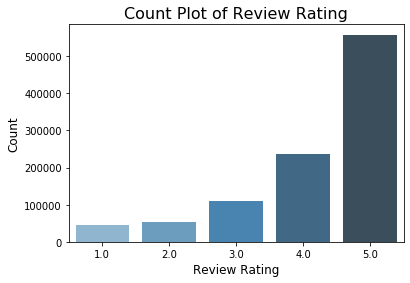

In [17]:
# Visualize of count distribution of Review Rating 
fig, ax = plt.subplots()
sns.countplot(x='overall', data=df_merge, palette="Blues_d") # try this palette
ax.set_title('Count Plot of Review Rating', fontsize=16)
ax.set_xlabel('Review Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

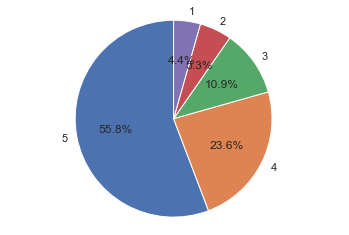

In [245]:
sizes = df_merge['overall'].value_counts()
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels= [5,4,3,2,1],autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

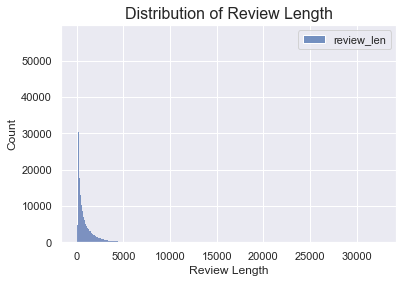

In [246]:
# Visualize Review Length
fig, ax = plt.subplots()
sns.histplot(df_merge[['review_len']])
ax.set_title('Distribution of Review Length', fontsize=16)
ax.set_xlabel('Review Length', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.show()

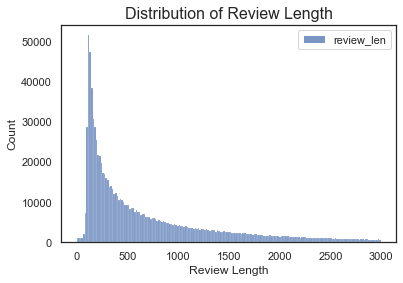

In [265]:
fig, ax = plt.subplots()
sns.histplot(df_merge[['review_len']][df_merge['review_len']<3000])
ax.set_title('Distribution of Review Length', fontsize=16)
ax.set_xlabel('Review Length', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
sns.set_style("white")
plt.show()

In [248]:
df_merge[['review_len']].describe()

,review_len
count,999998.000000
mean,850.156430
std,1070.422722
min,0.000000
25%,195.000000
50%,451.000000
75%,1093.000000
max,32623.000000


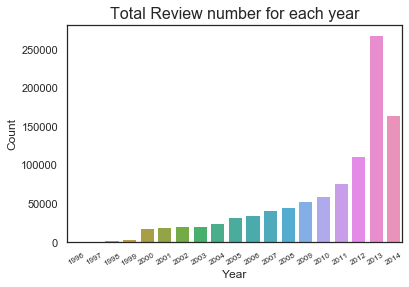

In [266]:
fig, ax = plt.subplots()
sns.countplot(x='year', data=df_merge) # try this palette
ax.set_title('Total Review number for each year', fontsize=16)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=30,fontsize=8)
sns.set_style("white")
plt.show()

In [312]:
np.mean(df_merge[['asin','helpful_ratio']].groupby(['asin']).mean())

helpful_ratio    0.452537
dtype: float64

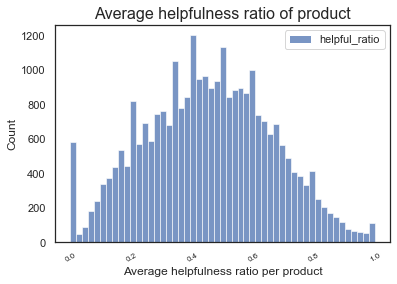

In [268]:
# Visualize helpful_ratio
fig, ax = plt.subplots()
sns.histplot(df_merge[['asin','helpful_ratio']].groupby(['asin']).mean())
ax.set_title('Average helpfulness ratio of product', fontsize=16)
ax.set_xlabel('Average helpfulness ratio per product', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=30,fontsize=8)
sns.set_style("white")
plt.show()

In [ ]:
# Visualize helpful_ratio
fig, ax = plt.subplots()
sns.histplot(df_merge[['asin','helpful_ratio']].groupby(['asin']).mean())
ax.set_title('Average helpfulness ratio of product', fontsize=16)
ax.set_xlabel('Average helpfulness ratio per product', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
plt.xticks(rotation=30,fontsize=8)
sns.set_style("white")
plt.show()

## Relationship between Review and Helpfulness 

Review Rating vs Helpfulness

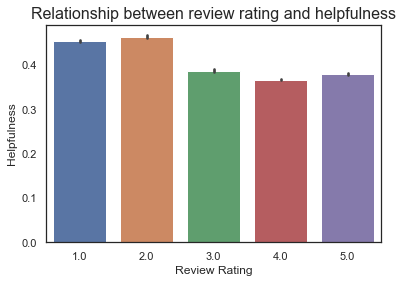

In [274]:
# review rating vs helful score
fig, ax = plt.subplots()
sns.barplot(x='overall', y='helpful_ratio', data=df_merge); 
ax.set_title('Relationship between review rating and helpfulness', fontsize=16)
ax.set_xlabel('Review Rating', fontsize=12)
ax.set_ylabel('Helpfulness', fontsize=12)
sns.set_style("white")
plt.show()

Review length vs Helpfulness

In [125]:
# Divide the review length into different interval
df_1 = df_merge[df_merge['review_len']<1000]
df_1['length_range'] = pd.cut(df_1['review_len'], bins=20)

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [126]:
pd.cut(df_1['review_len'], bins=20)

0         (149.85, 199.8]
1         (199.8, 249.75]
2          (99.9, 149.85]
3         (199.8, 249.75]
4         (149.85, 199.8]
               ...       
999990    (499.5, 549.45]
999991    (149.85, 199.8]
999994    (549.45, 599.4]
999995    (449.55, 499.5]
999997     (99.9, 149.85]
Name: review_len, Length: 726232, dtype: category
Categories (20, interval[float64]): [(-0.999, 49.95] < (49.95, 99.9] < (99.9, 149.85] < (149.85, 199.8] ... (799.2, 849.15] < (849.15, 899.1] < (899.1, 949.05] < (949.05, 999.0]]

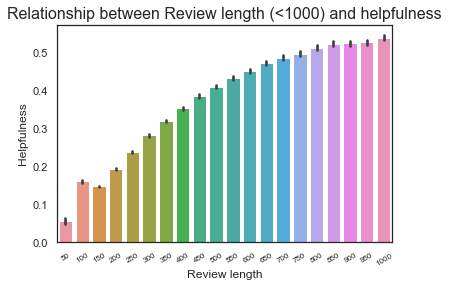

In [277]:
# review length vs helful score
fig, ax = plt.subplots()
sns.barplot(x='length_range', y='helpful_ratio', data=df_1); 
ax.set_title('Relationship between Review length (<1000) and helpfulness', fontsize=16)
ax.set_xlabel('Review length', fontsize=12)
ax.set_ylabel('Helpfulness', fontsize=12)
#ax.set_xticks()
ax.set_xticklabels(list(range(50,1050,50)),fontsize=8)
plt.xticks(rotation=30)
plt.show()

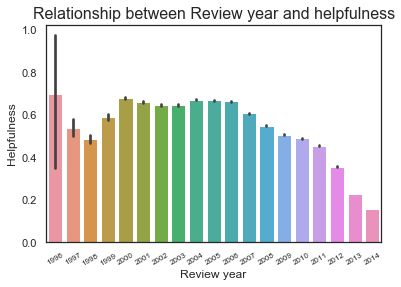

In [278]:
# review year vs helful score
fig, ax = plt.subplots()
sns.barplot(x='year', y='helpful_ratio', data=df_merge); 
ax.set_title('Relationship between Review year and helpfulness', fontsize=16)
ax.set_xlabel('Review year', fontsize=12)
ax.set_ylabel('Helpfulness', fontsize=12)
plt.xticks(rotation=30,fontsize=8)
sns.set_style("white")
plt.show()

## Relationship between price and review

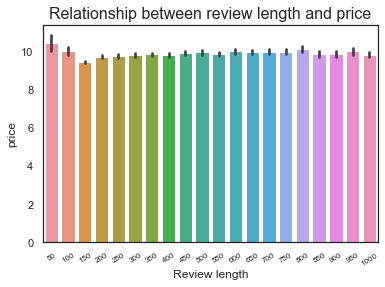

In [280]:
# Review length vs price 
fig, ax = plt.subplots()
sns.barplot(x='length_range', y='price', data=df_1,ci=95);
ax.set_title('Relationship between review length and price', fontsize=16)
ax.set_xlabel('Review length', fontsize=12)
ax.set_ylabel('price', fontsize=12)
ax.set_xticklabels(list(range(50,1050,50)),fontsize=8)
plt.xticks(rotation=30)
sns.set_style("white")
plt.show()

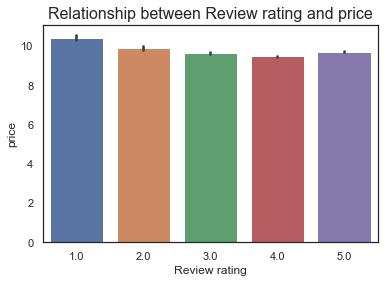

In [279]:
# Review rating vs price 
fig, ax = plt.subplots()
sns.barplot(x='overall', y='price', data=df_merge, ci=95);
ax.set_title('Relationship between Review rating and price', fontsize=16)
ax.set_xlabel('Review rating', fontsize=12)
ax.set_ylabel('price', fontsize=12)
sns.set_style("white")
plt.show()

## Review behavior among different categories

In [233]:
df_merge_c = df_merge.dropna(subset=['categories'])

In [234]:
df_merge_c['categories'] = df_merge_c['categories'].apply(lambda x: x[0][0])

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [235]:
df_merge_c['categories'].value_counts()

Books                        967248
Movies & TV                     391
Clothing, Shoes & Jewelry       196
CDs & Vinyl                      18
Cell Phones & Accessories        15
Sports & Outdoors                 5
Name: categories, dtype: int64

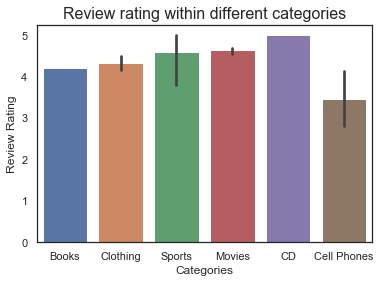

In [281]:
# Review rating within different categories
fig, ax = plt.subplots()
sns.barplot(x='categories', y='overall', data=df_merge_c)
ax.set_title('Review rating within different categories', fontsize=16)
ax.set_xlabel('Categories', fontsize=12)
ax.set_ylabel('Review Rating', fontsize=12)
ax.set_xticklabels(['Books','Clothing','Sports','Movies','CD','Cell Phones'])
#plt.xticks(rotation=30)
sns.set_style("white")
plt.show()

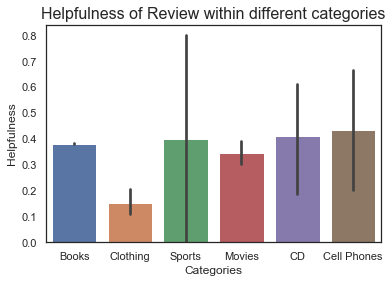

In [282]:
# Helpfulness of Review within different categories
fig, ax = plt.subplots()
sns.barplot(x='categories', y='helpful_ratio', data=df_merge_c)
ax.set_title('Helpfulness of Review within different categories', fontsize=16)
ax.set_xlabel('Categories', fontsize=12)
ax.set_ylabel('Helpfulness', fontsize=12)
ax.set_xticklabels(['Books','Clothing','Sports','Movies','CD','Cell Phones'])
sns.set_style("white")
plt.show()

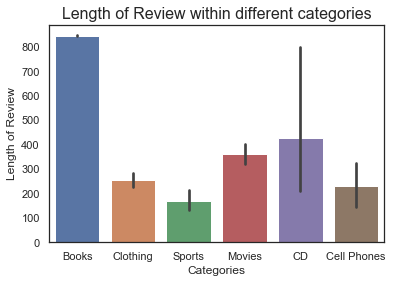

In [283]:
# Length of Review within different categories
fig, ax = plt.subplots()
sns.barplot(x='categories', y='review_len', data=df_merge_c)
ax.set_title('Length of Review within different categories', fontsize=16)
ax.set_xlabel('Categories', fontsize=12)
ax.set_ylabel('Length of Review', fontsize=12)
ax.set_xticklabels(['Books','Clothing','Sports','Movies','CD','Cell Phones'])
sns.set_style("white")
plt.show()

## Relation between reviews from products which are bought together.

In [209]:
df_merge_1 = df_merge[['reviewerID','asin','helpful_ratio','related','review_len','overall']]

In [210]:
df_merge_1.dropna(subset=['related'],inplace=True)
df_merge_1['bought_together'] = df_merge_1['related'].apply(lambda x: x.get('bought_together'))
df_merge_1.dropna(subset = ['bought_together'],inplace=True)
df_merge_1['together_len'] = df_merge_1['bought_together'].apply(len)

/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://panda

In [211]:
df_merge_1['together_len'].value_counts()

2    409694
1    182130
4         5
Name: together_len, dtype: int64

In [212]:
def func_1(x):
    if len(x)==1:
        return np.nan
    else:
        return x[1]

In [213]:
df_merge_1 = df_merge_1[['asin','bought_together']]
df_merge_1['first'] = df_merge_1['bought_together'].apply(lambda x: x[0])
df_merge_1['second'] = df_merge_1['bought_together'].apply(func_1)
df_merge_1.drop_duplicates(subset=['asin','first','second'],inplace=True)
df_merge_1 = df_merge_1[['asin','first','second']]

In [214]:
df_merge_2 = df_merge[['asin','helpful_ratio','review_len','overall']].groupby(['asin']).mean().reset_index()

In [215]:
df_merge_all = pd.merge(df_merge_2,df_merge_1, how='right',on='asin')

In [216]:
df_merge_all = pd.merge(df_merge_2,df_merge_all, how='right',left_on='asin',right_on='first')

In [217]:
df_merge_all = pd.merge(df_merge_2,df_merge_all, how='right',left_on='asin',right_on='second')

In [218]:
df_merge_all.dropna(subset=['asin'],inplace=True)

In [219]:
df_merge_all['overall_avg'] = df_merge_all[['overall_x','overall_y']].mean(axis=1)
df_merge_all['review_avg'] = df_merge_all[['review_len_x','review_len_y']].mean(axis=1)
df_merge_all['helpfulness_avg'] = df_merge_all[['helpful_ratio_x','helpful_ratio_y']].mean(axis=1)

In [240]:
df_merge_all.head()

,asin,helpful_ratio,review_len,overall,asin_x,helpful_ratio_x,review_len_x,overall_x,asin_y,helpful_ratio_y,review_len_y,overall_y,first,second,overall_avg,review_avg,helpfulness_avg
0,0000013714,0.133333,191.000000,4.40,NaN,NaN,NaN,NaN,0005064341,0.000000,161.000000,4.800000,0005064295,0000013714,4.800000,161.000000,0.000000
1,0005448506,0.444444,200.833333,5.00,0005235073,0.000000,157.090909,4.909091,0006458718,0.800000,204.400000,5.000000,0005235073,0005448506,4.954545,180.745455,0.400000
2,0005448506,0.444444,200.833333,5.00,0006458718,0.800000,204.400000,5.000000,0005235073,0.000000,157.090909,4.909091,0006458718,0005448506,4.954545,180.745455,0.400000
3,0006458718,0.800000,204.400000,5.00,0005235073,0.000000,157.090909,4.909091,0005448506,0.444444,200.833333,5.000000,0005235073,0006458718,4.954545,178.962121,0.222222
4,0007101082,0.469206,1494.280000,3.76,0007101147,0.656384,1678.153846,4.230769,0007217811,0.150000,971.666667,4.500000,0007101147,0007101082,4.365385,1324.910256,0.403192


In [241]:
df_merge_all[['overall','overall_x']].corr(method='pearson')

,overall,overall_x
overall,1.00000,0.54009
overall_x,0.54009,1.00000


In [221]:
df_merge_all[['overall','overall_y']].corr(method='pearson')

,overall,overall_y
overall,1.000000,0.461265
overall_y,0.461265,1.000000


In [222]:
df_merge_all[['overall_x','overall_y']].corr(method='pearson')

,overall_x,overall_y
overall_x,1.000000,0.569031
overall_y,0.569031,1.000000


Text(0.5, 1.0, 'Review ratings between products which are bought together')

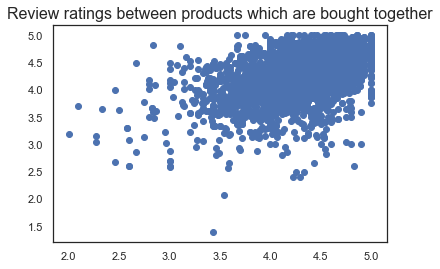

In [297]:
fig, ax = plt.subplots()
plt.scatter(df_merge_all['overall'],df_merge_all['overall_avg'])
ax.set_title('Review ratings between products which are bought together', fontsize=16)

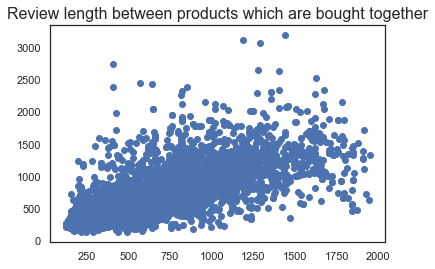

In [306]:
fig, ax = plt.subplots()
df_merge_all_1 = df_merge_all[df_merge_all['review_len']<2000]
plt.scatter(df_merge_all_1['review_len'],df_merge_all_1['review_avg'])
ax.set_title('Review length between products which are bought together', fontsize=16)
plt.show()

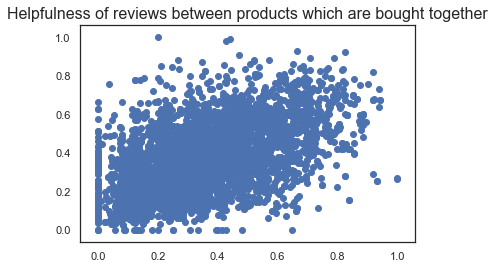

In [307]:
fig, ax = plt.subplots()
plt.scatter(df_merge_all['helpful_ratio'],df_merge_all['helpfulness_avg'])
ax.set_title('Helpfulness of reviews between products which are bought together', fontsize=16)
plt.show()

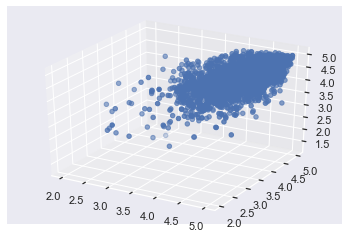

In [285]:
sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = df_merge_all['overall']
y = df_merge_all['overall_x']
z = df_merge_all['overall_y']

ax.scatter(x, y, z)
sns.set_style("white")
plt.show()

In [293]:
df_merge_all[['overall','overall_avg']].corr(method='spearman')

,overall,overall_avg
overall,1.000000,0.515608
overall_avg,0.515608,1.000000


In [294]:
df_merge_all[['helpful_ratio','helpfulness_avg']].corr(method='spearman')

,helpful_ratio,helpfulness_avg
helpful_ratio,1.000000,0.520743
helpfulness_avg,0.520743,1.000000


In [295]:
df_merge_all[['review_len','review_avg']].corr(method='spearman')

,review_len,review_avg
review_len,1.000000,0.740154
review_avg,0.740154,1.000000
